In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from braindecode.models import EEGNetv4
import copy
import random
import pandas as pd
from tqdm import notebook
import tqdm
from pathlib import Path
import numpy as np
import scipy


torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\machi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
c:\Users\machi\anaconda3\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be ab

'NVIDIA GeForce GTX 1650'

# Utilities

In [2]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    get_windows,
    load_data_from_users,
    get_windows,
)

In [3]:
from cca import CCA_otimizacao, matriz_referencia

# Cross Subject

In [4]:
freq_phase_path = (
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
freq_phase = scipy.io.loadmat(freq_phase_path)
frequencias = np.round(freq_phase["freqs"], 2).ravel()
fases = freq_phase["phases"]

# Parâmetros do pré-processamento
sample_rate = 250
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6
delay = 160

# Parâmetros do CCA
num_harmonica = 5
inform_fase = 0

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))

occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 1000
exp_dir = Path(
    f"CCA/{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [5]:
print("Usuários de interesse:", users)
print(f"Frequencies used: {frequencias_desejadas}")
print(f"Frequencies indices: {indices}")
print(f"Tamanho da janela: {tamanho_da_janela} samples ({tamanho_da_janela_seg} s)")

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies used: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Frequencies indices: [0, 1, 2, 3, 4, 5, 6, 7]
Tamanho da janela: 250 samples (1 s)


In [6]:
all_data = load_data_from_users(
    users,
    visual_delay=delay,
    filter_bandpass=True,
    sample_rate=sample_rate,
    freq_cut_low=freq_cut_low,
    freq_cut_high=freq_cut_high,
    filter_order=filter_order,
)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

# CCA

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    recall_score,
    accuracy_score,
)
import matplotlib.pyplot as plt


def evaluate(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test set Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    classes = np.unique(np.concatenate((all_labels, all_preds)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
    plt.show()
    return accuracy, recall, f1, cm

Processando Usuário 1
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 13.0 Hz: (250, 10, 8)
6
Generating reference for frequency ind

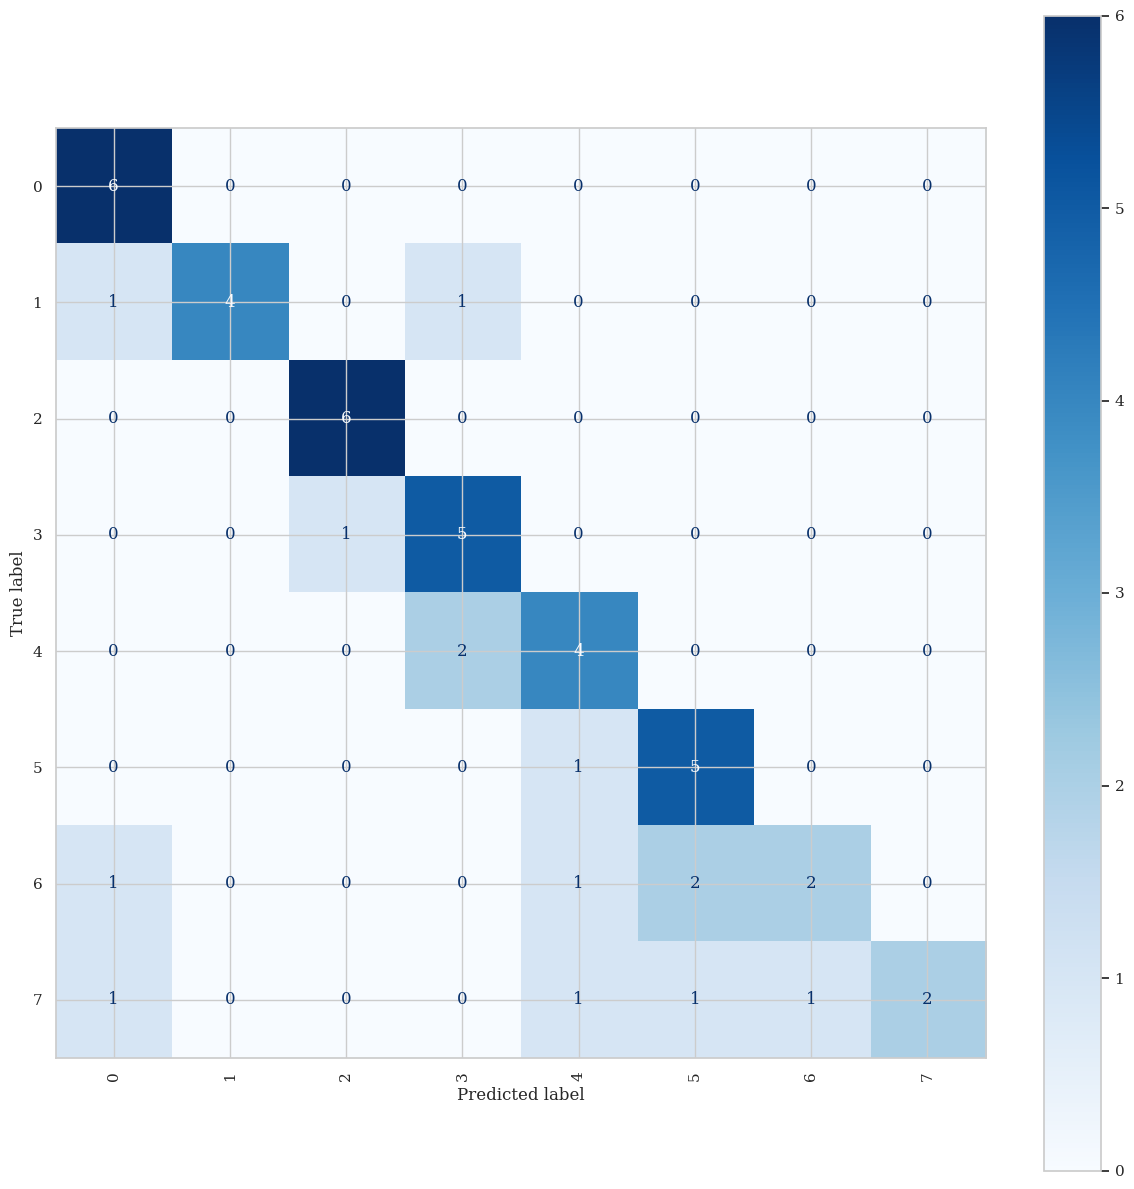

Test User 1 Finished: Accuracy=0.7083, Recall=0.7083, F1=0.6889
--------------------------------------------------
Processando Usuário 2
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

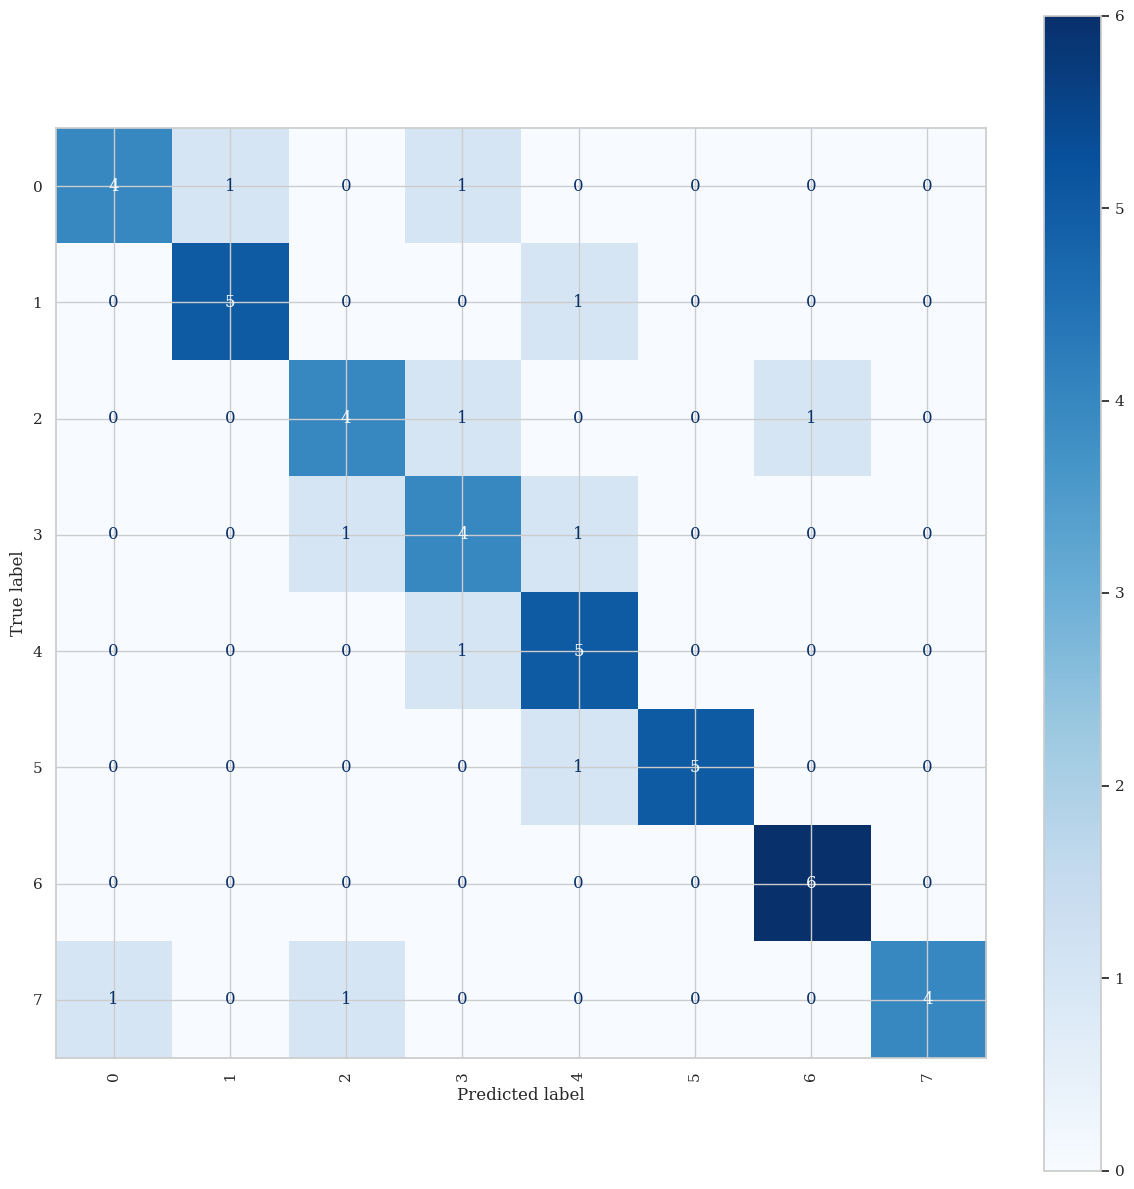

Test User 2 Finished: Accuracy=0.7708, Recall=0.7708, F1=0.7736
--------------------------------------------------
Processando Usuário 3
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

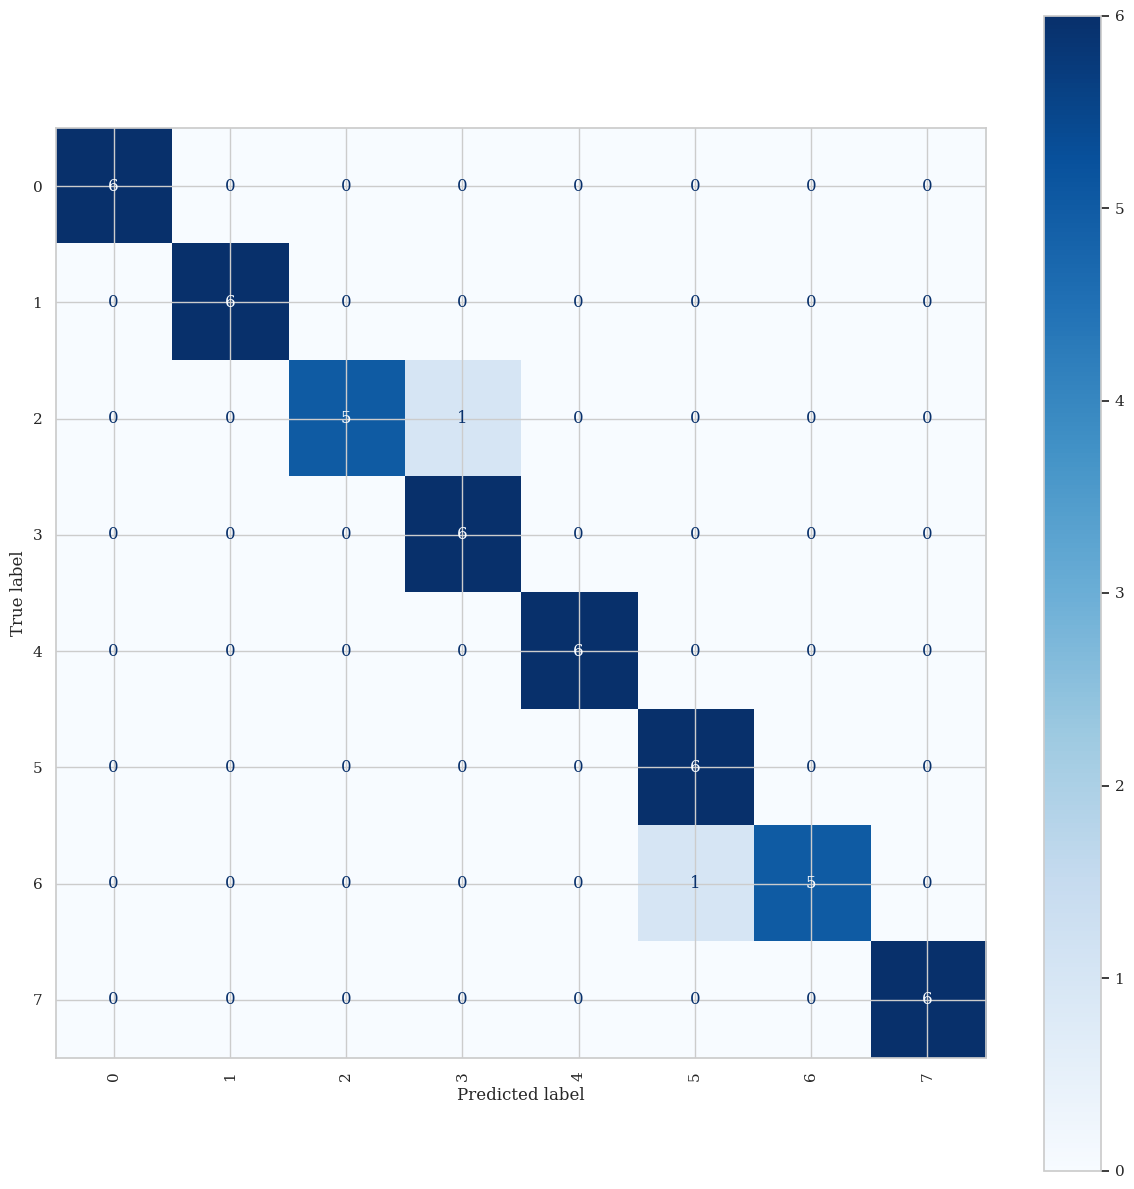

Test User 3 Finished: Accuracy=0.9583, Recall=0.9583, F1=0.9580
--------------------------------------------------
Processando Usuário 4
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

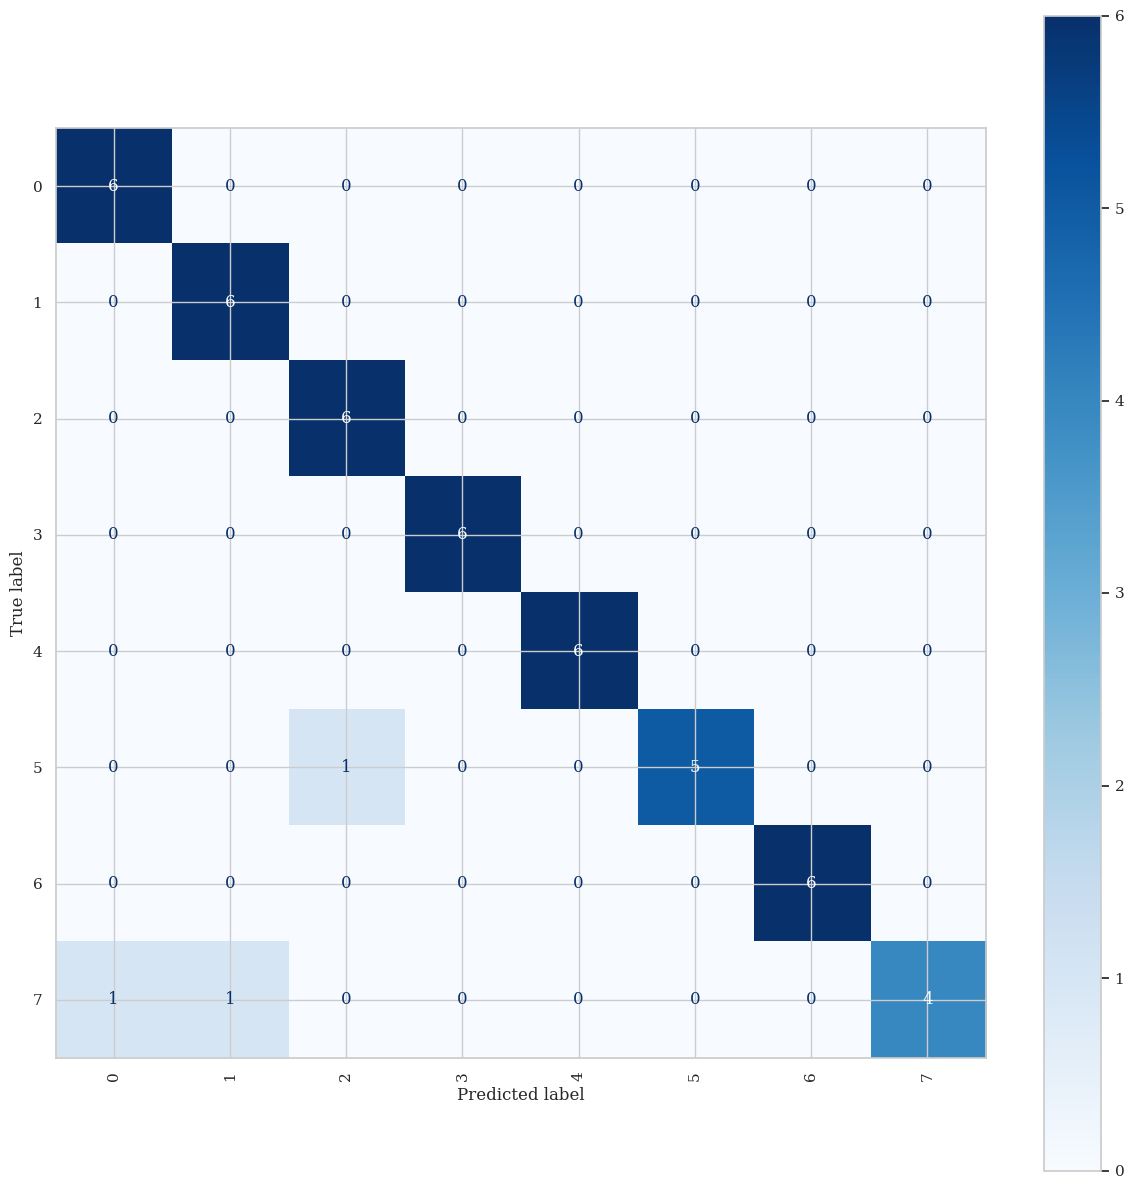

Test User 4 Finished: Accuracy=0.9375, Recall=0.9375, F1=0.9348
--------------------------------------------------
Processando Usuário 5
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

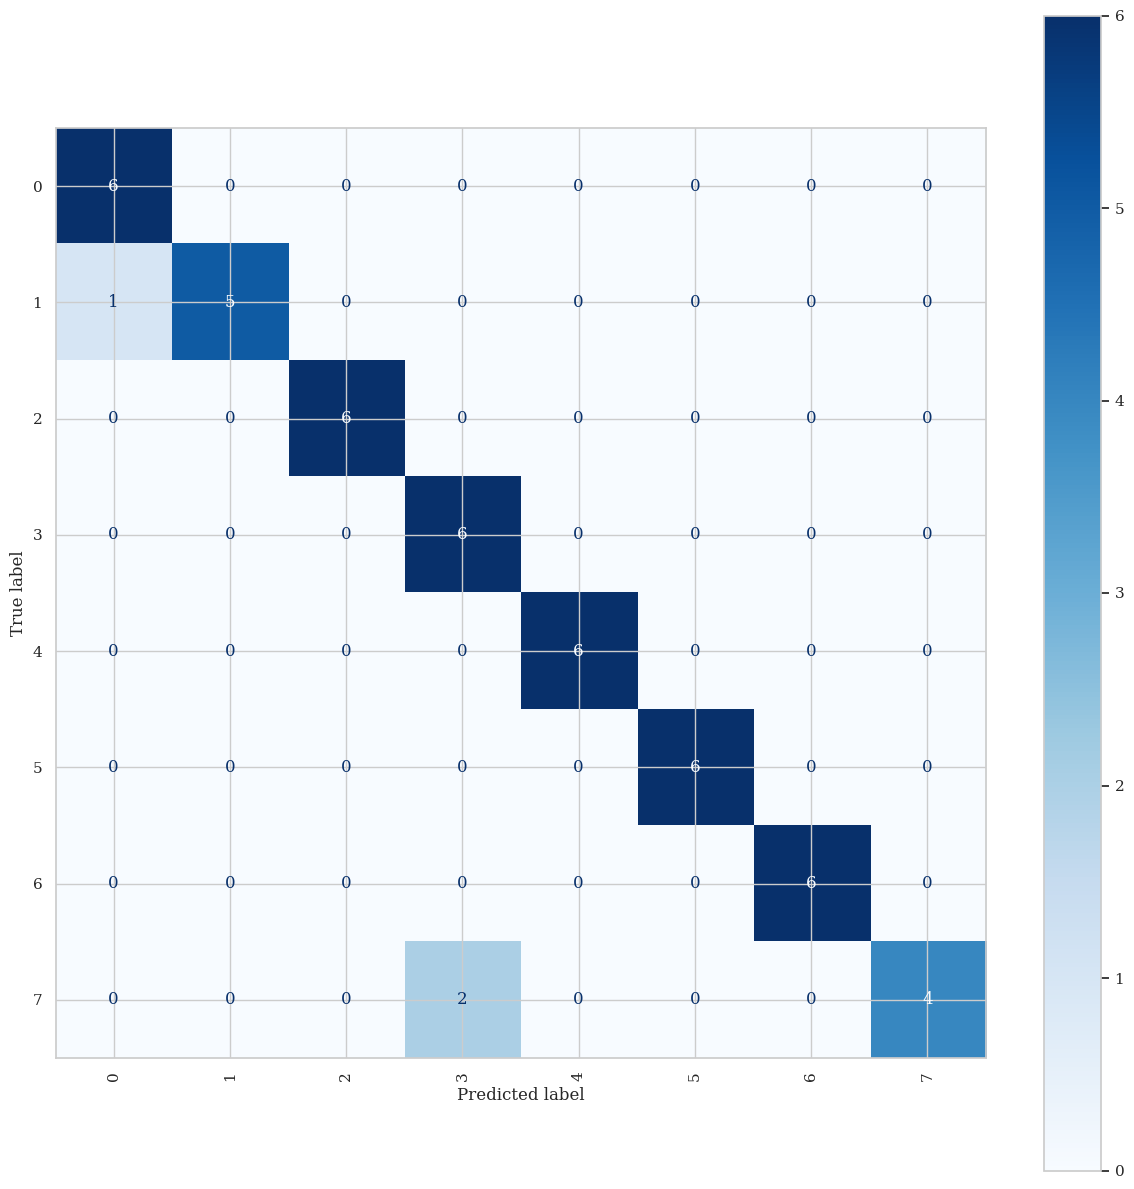

Test User 5 Finished: Accuracy=0.9375, Recall=0.9375, F1=0.9362
--------------------------------------------------
Processando Usuário 6
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

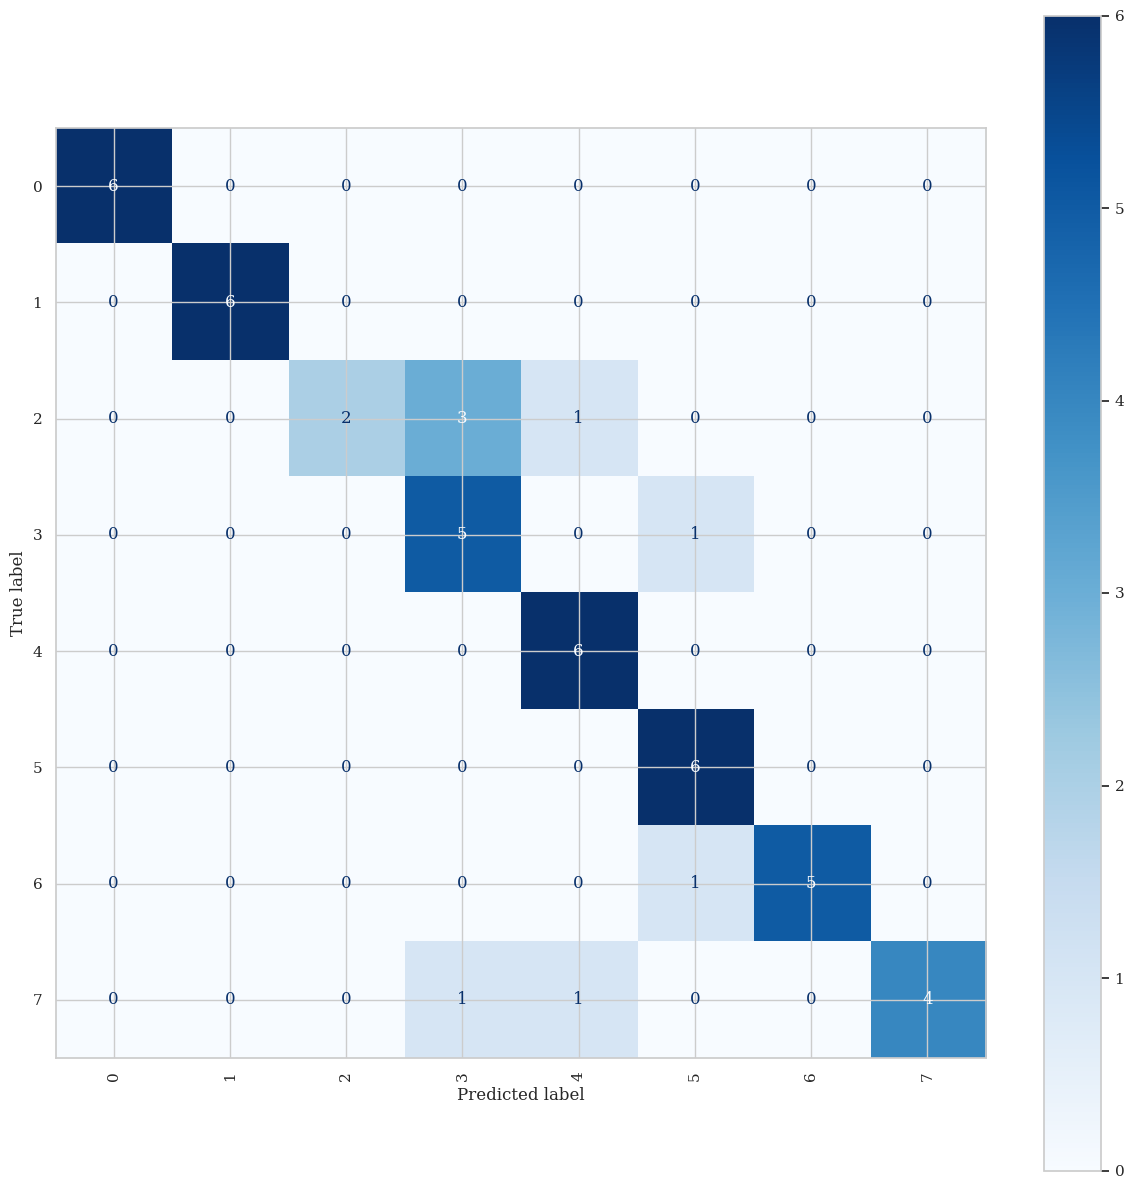

Test User 6 Finished: Accuracy=0.8333, Recall=0.8333, F1=0.8238
--------------------------------------------------
Processando Usuário 7
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

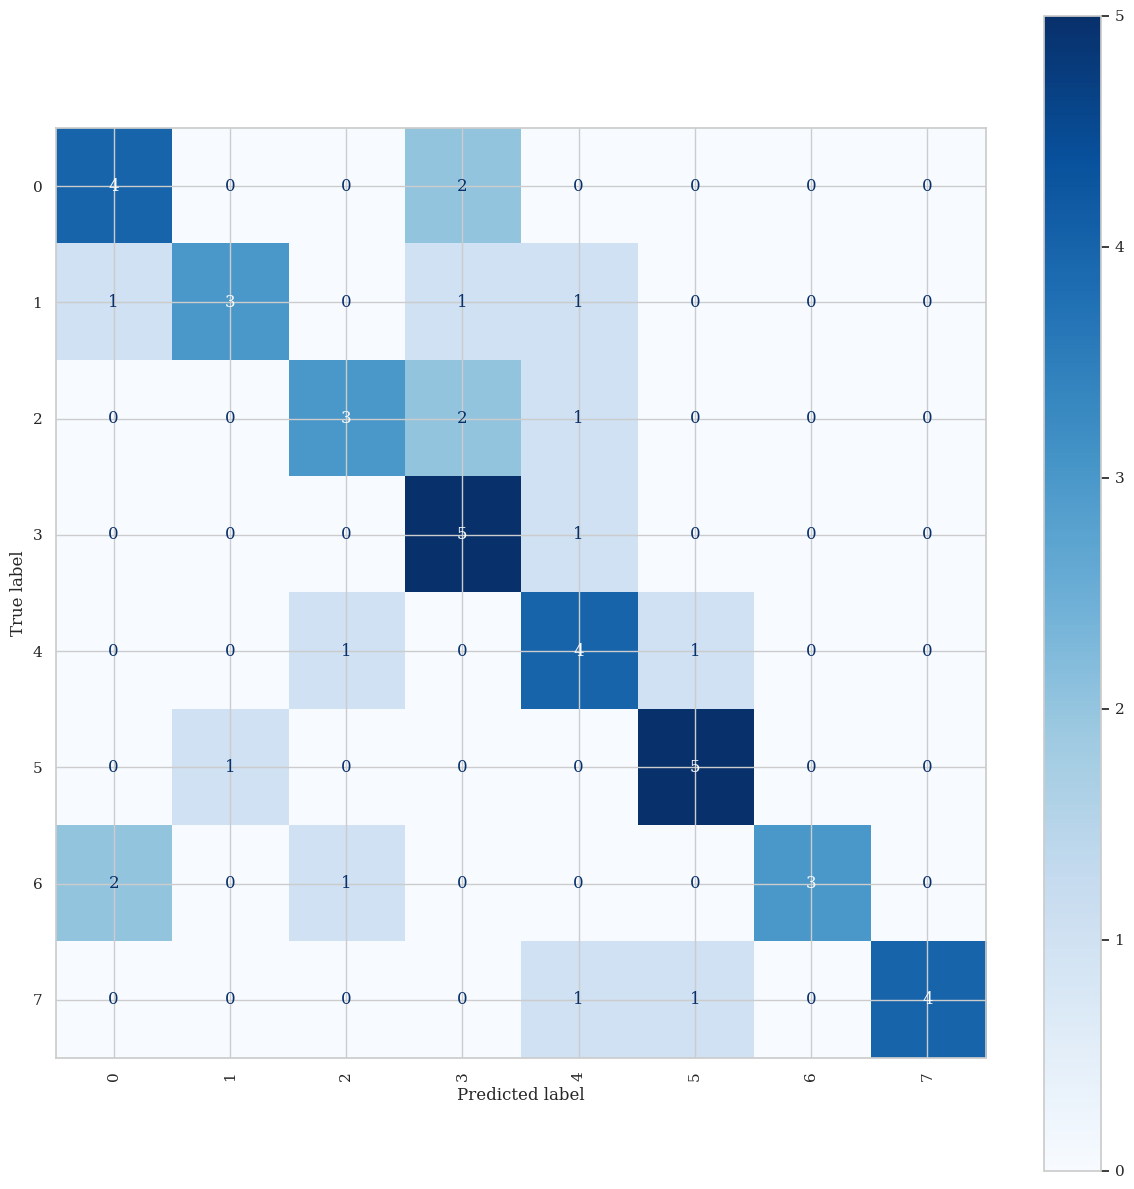

Test User 7 Finished: Accuracy=0.6458, Recall=0.6458, F1=0.6491
--------------------------------------------------
Processando Usuário 8
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

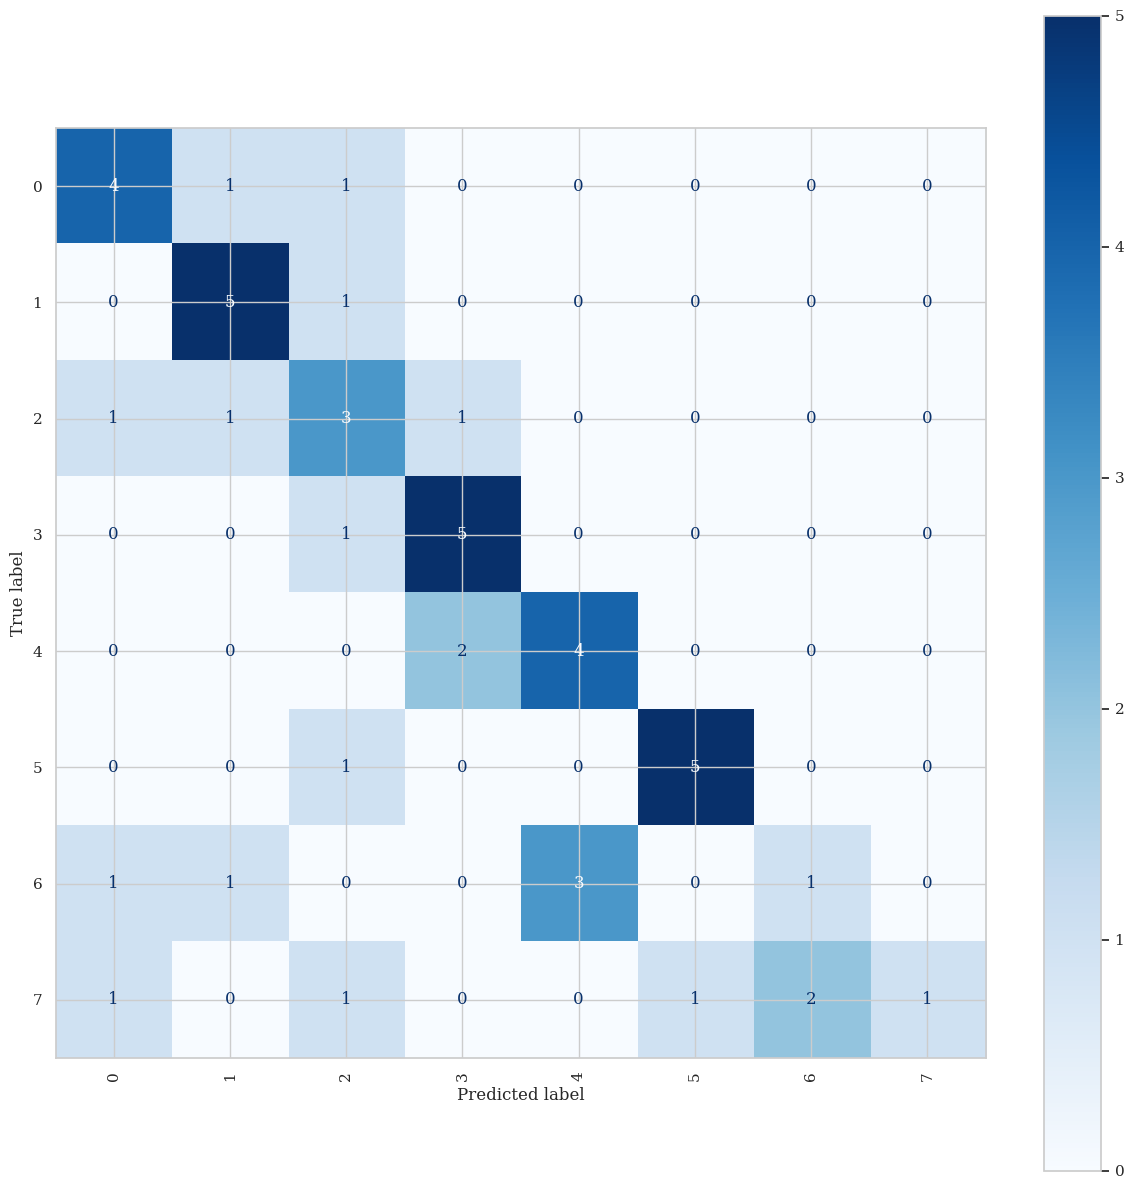

Test User 8 Finished: Accuracy=0.5833, Recall=0.5833, F1=0.5536
--------------------------------------------------
Processando Usuário 9
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape: 

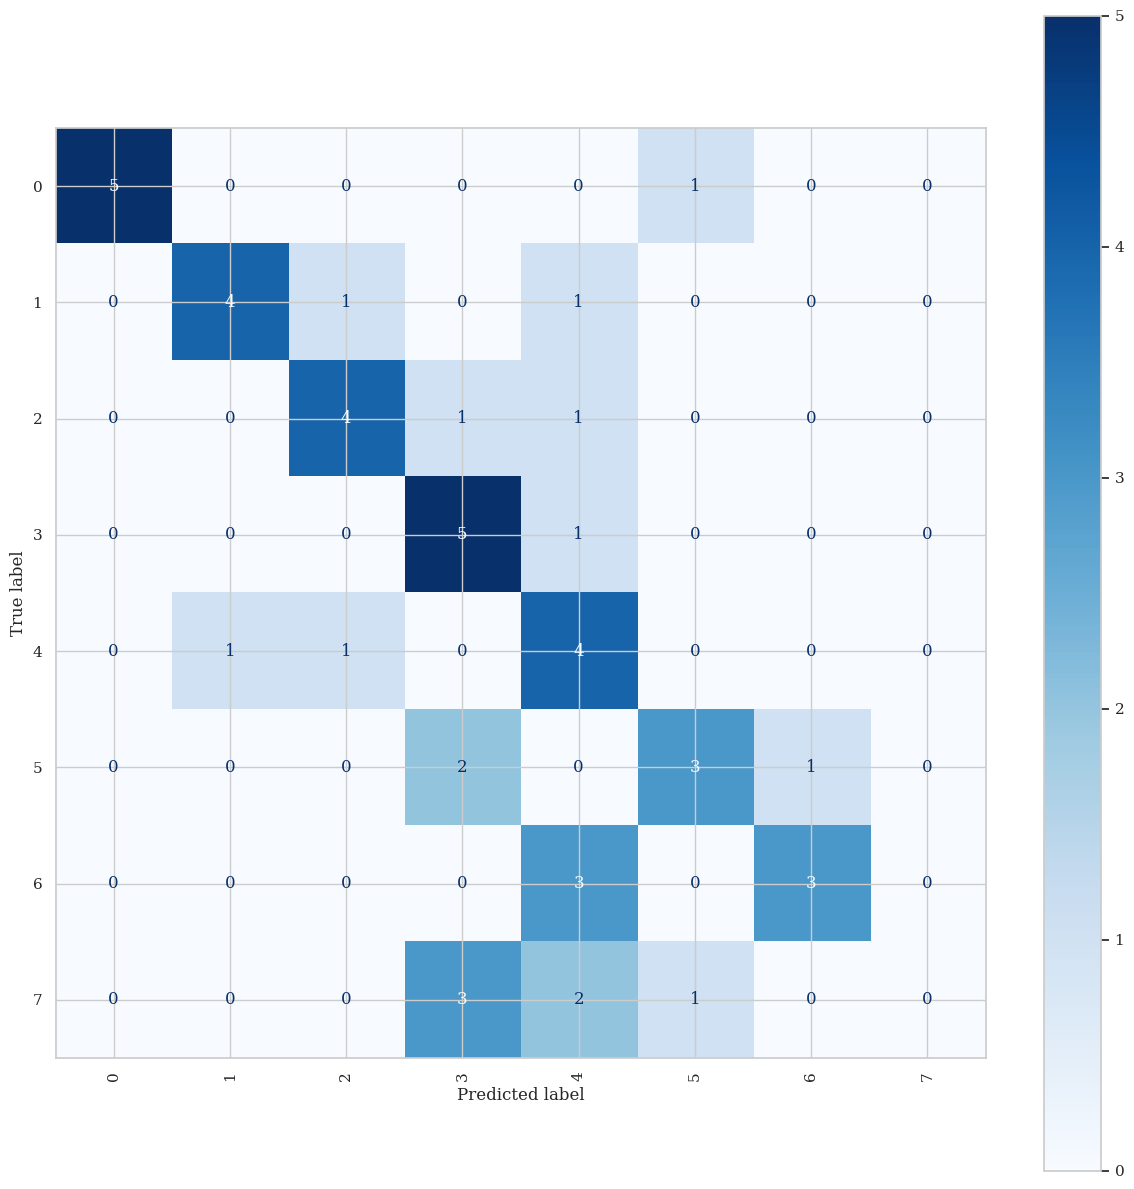

Test User 9 Finished: Accuracy=0.5833, Recall=0.5833, F1=0.5601
--------------------------------------------------
Processando Usuário 10
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 8.0 Hz: (250, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 9.0 Hz: (250, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 10.0 Hz: (250, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 11.0 Hz: (250, 10, 8)
4
Generating reference for frequency index 4, frequency 12.0 Hz
theta: 0
y shape: (250, 10)
Y shape: (250, 10)
Y_test shape after freq 12.0 Hz: (250, 10, 8)
5
Generating reference for frequency index 5, frequency 13.0 Hz
theta: 0
y shape:

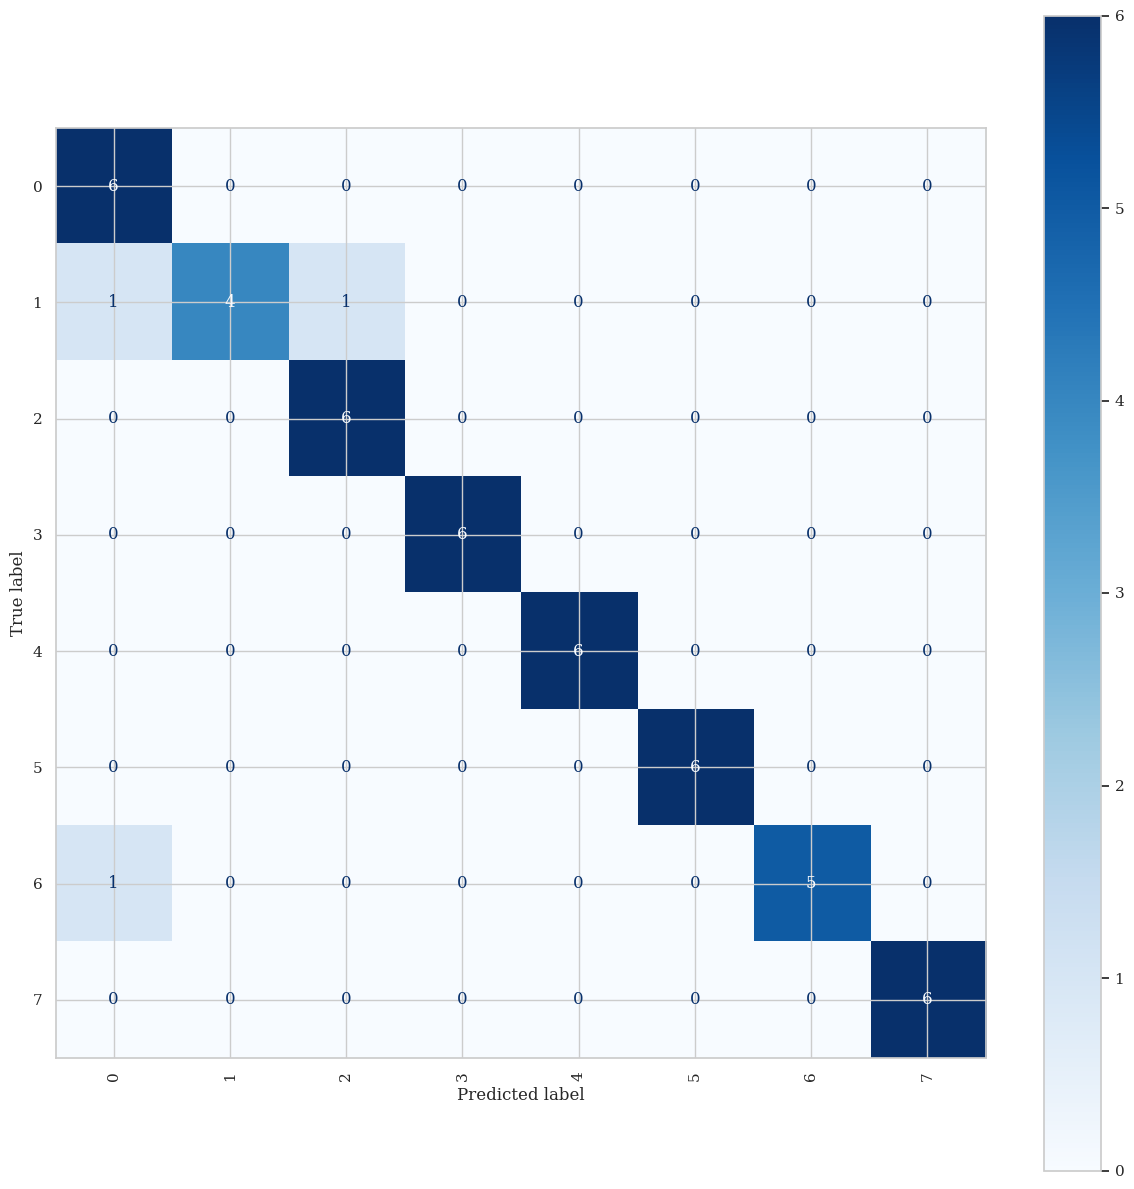

Test User 10 Finished: Accuracy=0.9375, Recall=0.9375, F1=0.9362
--------------------------------------------------


In [8]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# Cross-Subject EEGNet Training (single window per trial, no window separation)
metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

# Prepare cross-subject splits
for test_user_idx, test_user in enumerate(users):
    print(f"Processando Usuário {test_user}")

    test_data = all_data[test_user_idx]
    num_trials_test = test_data.shape[-1]

    Y_test = np.zeros((tamanho_da_janela, num_harmonica * 2, len(indices)))
    for k in indices:
        print(k)
        print(
            f"Generating reference for frequency index {k}, frequency {frequencias[k]} Hz"
        )
        y_test = matriz_referencia(
            num_harmonica,
            inform_fase,
            1,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_test[:, :, k] = y_test
        print(f"Y_test shape after freq {frequencias[k]} Hz: {Y_test.shape}")

    labels = []
    predictions = []
    for k in range(len(indices)):
        for session in range(num_trials_test):
            # For training: each trial is a single window
            eeg_matrix_test = test_data[
                occipital_electrodes, :tamanho_da_janela, indices[k], session
            ]

            # Transpõe os dados para que cada linha represente uma amostra
            eeg_matrix_test = np.transpose(eeg_matrix_test)
            labels.append(k)
            corrs = np.zeros(len(indices))
            for freq in range(len(indices)):
                Wx, Wy, corr = CCA_otimizacao(eeg_matrix_test, Y_test[:, :, freq])
                corrs[freq] = corr
            predicted_label = np.argmax(corrs)
            predictions.append(predicted_label)

    accuracy, recall, f1, cm = evaluate(labels, predictions)
    metricas_usuarios.append(
        {
            "usuario": test_user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Test User {test_user} Finished: Accuracy={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath("metricas.csv"), index=False)

    print("-" * 50)